In [81]:
# --- Imports ---
import os
import re
import pandas as pd
import torch
from typing import List, Dict
from sentence_transformers import SentenceTransformer, util
import json


In [83]:
# --- Configuration ---
COMPANY_DATA_PATH = "Task-1-data(130 company).csv"
EMBEDDING_MODEL = 'BAAI/bge-base-en-v1.5'


In [91]:
print("First 5 rows of the DataFrame:")
print(df.head())

print("\nData types of each column:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

First 5 rows of the DataFrame:
   #    company_name                                  short_description  \
0  1  Animoca Brands  A leading Hong Kong-based blockchain gaming an...   
1  2       Immutable  Australian crypto-game studio building scalabl...   
2  3          Kwalee  UK-based mobile game developer focused on hype...   
3  4   Stepico Games  Ukrainian game development studio making web3 ...   
4  5          GLITCH  Indie game development firm in Minnesota, smal...   

              industry     employes   location  \
0  Gaming / Blockchain  1.000000000  Hong Kong   
1  Gaming / Blockchain          200  Australia   
2               Gaming          180         UK   
3        Gaming / Web3       200.0+    Ukraine   
4          Indie Games           11        USA   

                       tech_stack  \
0      [Ethereum, Polygon, Unity]   
1  [Immutable X, Solidity, Unity]   
2           [Unity, Firebase, C#]   
3               [Unity, Solidity]   
4          [Custom Engine, Unity

In [92]:
print("Descriptive statistics for numerical columns:")
print(df.describe())

print("\nValue counts for 'industry' column:")
print(df['industry'].value_counts())

print("\nValue counts for 'location' column:")
print(df['location'].value_counts())

Descriptive statistics for numerical columns:
                #  similarity_score
count  130.000000        130.000000
mean    65.500000          0.595470
std     37.671829          0.083337
min      1.000000          0.447001
25%     33.250000          0.541225
50%     65.500000          0.568162
75%     97.750000          0.616052
max    130.000000          0.795110

Value counts for 'industry' column:
industry
Web3 Gaming                    18
Fashion / E-commerce           15
Gaming                          6
Indie Games                     5
Gaming / Blockchain             4
                               ..
Web3 Platform / Game Dev        1
Mobility / E-commerce           1
E-commerce / Grocery            1
E-commerce / Food / Fashion     1
E-commerce / Mobility           1
Name: count, Length: 65, dtype: int64

Value counts for 'location' column:
location
USA                      27
Bangladesh               13
India                    12
South Korea               5
USA / Global  

In [84]:
# --- Utility Functions ---
def generate_mmr_explanation(
    query_description: str,
    company_description: str,
    model: SentenceTransformer,
    top_n: int = 4
) -> str:
    """
    Generates a solid explanation using MMR sentence selection.
    """
    sentences = re.split(
        r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s',
        company_description
    )
    sentences = [s.strip() for s in sentences if s.strip()]

    if len(sentences) <= 1:
        return company_description.strip()

    sentence_embeddings = model.encode(
        sentences,
        convert_to_tensor=True,
        normalize_embeddings=True
    )
    query_embedding = model.encode(
        query_description,
        convert_to_tensor=True,
        normalize_embeddings=True
    )

    relevance_scores = util.cos_sim(query_embedding, sentence_embeddings)[0]
    selected_indices = []

    best_idx = torch.argmax(relevance_scores).item()
    selected_indices.append(best_idx)

    for _ in range(top_n - 1):
        candidate_indices = [
            i for i in range(len(sentences))
            if i not in selected_indices
        ]
        if not candidate_indices:
            break

        max_mmr = -float("inf")
        best_candidate_idx = -1
        selected_embeds = sentence_embeddings[selected_indices]

        for idx in candidate_indices:
            candidate_embed = sentence_embeddings[idx].unsqueeze(0)
            redundancy = util.cos_sim(candidate_embed, selected_embeds).max().item()
            mmr_score = 0.6 * relevance_scores[idx].item() - 0.4 * redundancy

            if mmr_score > max_mmr:
                max_mmr = mmr_score
                best_candidate_idx = idx

        if best_candidate_idx != -1:
            selected_indices.append(best_candidate_idx)

    selected_sentences = [sentences[i] for i in sorted(selected_indices)]
    explanation = " ".join(selected_sentences).strip()

    return f"This company matches the ICP because: {explanation}"


In [85]:
# --- Load Data ---
df = pd.read_csv(COMPANY_DATA_PATH)
print(f"Loaded {len(df)} companies.")

# ICP description
icp_description = (
    "We are looking for e-commerce and fashion companies in Bangladesh "
    "with scalable online presence."
)

print("ICP Description:")
print(icp_description)

# Build combined features
df['combined_features'] = df.apply(
    lambda r: (
        f"{r['short_description']} "
        f"Industry: {r['industry']}. "
        f"Tech: {r.get('tech_stack', '')}. "
        f"Location: Bangladesh-focused if applicable."
    ),
    axis=1
)

df.head()


Loaded 130 companies.
ICP Description:
We are looking for e-commerce and fashion companies in Bangladesh with scalable online presence.


,#,company_name,short_description,industry,employes,location,tech_stack,combined_features
0,1,Animoca Brands,A leading Hong Kong-based blockchain gaming an...,Gaming / Blockchain,1.000000000,Hong Kong,"[Ethereum, Polygon, Unity]",A leading Hong Kong-based blockchain gaming an...
1,2,Immutable,Australian crypto-game studio building scalabl...,Gaming / Blockchain,200,Australia,"[Immutable X, Solidity, Unity]",Australian crypto-game studio building scalabl...
2,3,Kwalee,UK-based mobile game developer focused on hype...,Gaming,180,UK,"[Unity, Firebase, C#]",UK-based mobile game developer focused on hype...
3,4,Stepico Games,Ukrainian game development studio making web3 ...,Gaming / Web3,200.0+,Ukraine,"[Unity, Solidity]",Ukrainian game development studio making web3 ...
4,5,GLITCH,"Indie game development firm in Minnesota, smal...",Indie Games,11,USA,"[Custom Engine, Unity]","Indie game development firm in Minnesota, smal..."


/tmp/ipython-input-2272661714.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.index, y=industry_counts.values, palette='viridis')


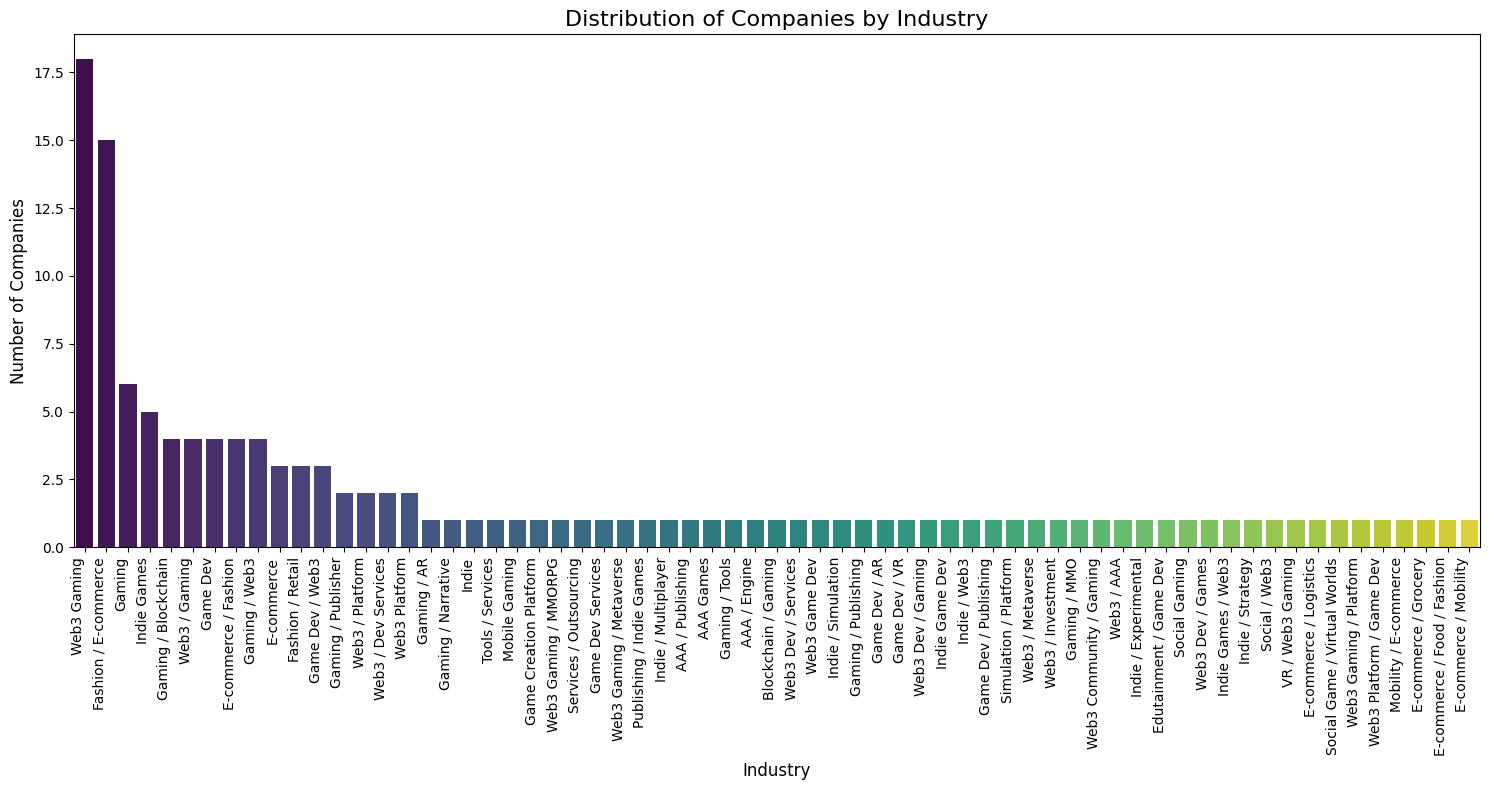

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate value counts for the 'industry' column
industry_counts = df['industry'].value_counts()

# Set figure size for better readability, especially with many industries
plt.figure(figsize=(15, 8))

# Create a bar plot
sns.barplot(x=industry_counts.index, y=industry_counts.values, palette='viridis')

# Add title and labels
plt.title('Distribution of Companies by Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)

# Rotate x-axis labels for better readability if there are many industries
plt.xticks(rotation=90, ha='right', fontsize=10)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()

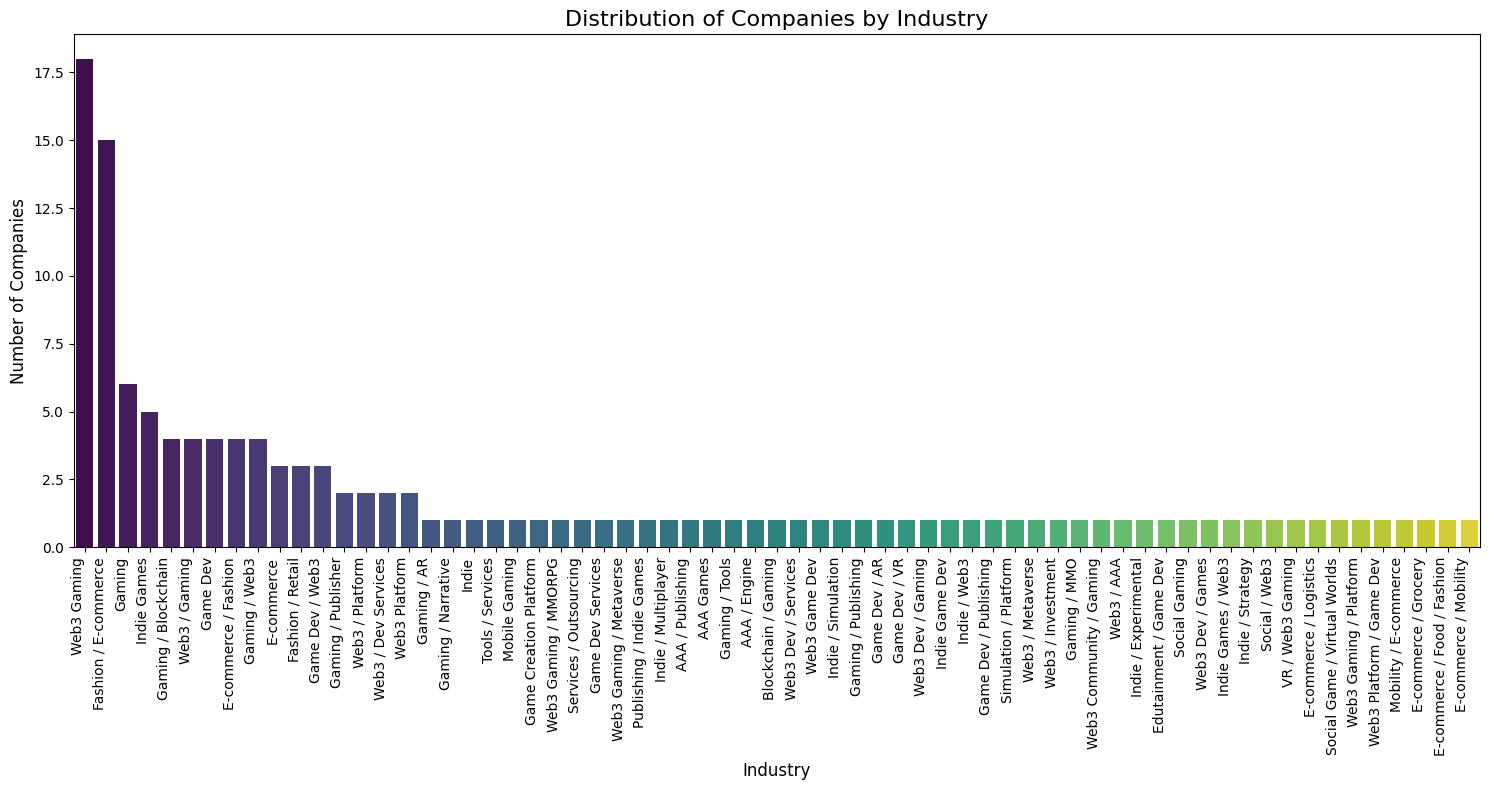

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate value counts for the 'industry' column
industry_counts = df['industry'].value_counts()

# Set figure size for better readability, especially with many industries
plt.figure(figsize=(15, 8))

# Create a bar plot, addressing the FutureWarning by assigning x to hue and setting legend=False
sns.barplot(x=industry_counts.index, y=industry_counts.values, hue=industry_counts.index, palette='viridis', legend=False)

# Add title and labels
plt.title('Distribution of Companies by Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)

# Rotate x-axis labels for better readability if there are many industries
plt.xticks(rotation=90, ha='right', fontsize=10)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()

In [95]:
print("Unique values in 'employes' column before cleaning:")
print(df['employes'].unique())

Unique values in 'employes' column before cleaning:
['1.000000000' '200' '180' '200.0+' '11' '300' '120' '250' '150' '3,000+'
 '5.000000000' '400' '600' '1,000+' '20,000+' '50' '80' '30' '45' '60'
 '10' '15' '8' '12' '70' '100 (51–200) (LeadIQ)' '150 (estimate)'
 '80 (10–50 by LinkedIn; some reports 100+) (SignalHire)' '60 (estimate)'
 '40 (estimate)' '50 (estimate)' '120 (estimate)' '2' '60–120 (estimate)'
 '145' '70 (estimate)' '100 (estimate)' '30 (estimate)' '25 (estimate)'
 '35 (estimate)' '20 (estimate)' '500 (estimate)' '200 (estimate)'
 '300 (estimate)' '250 (estimate)' '80 (estimate)' '40 (est staff)'
 '20 (core team)' '400+ (estimate)' '200+ (estimate)' '15 (estimate)'
 '500+ (larger)' '90 (estimate)' '75 (estimate)' '300+ (estimate)'
 '3,000+ (global)' '45 (estimate)' '40' '20' '55 (estimate)' '2,000+'
 '500' '350' '15,000+' '120,000+' '15.000000000' '6.000000000' '100'
 '100,000+' '4.000000000' '10.000000000' '8.000000000' '2.000000000'
 '50.000000000' '50,000+']


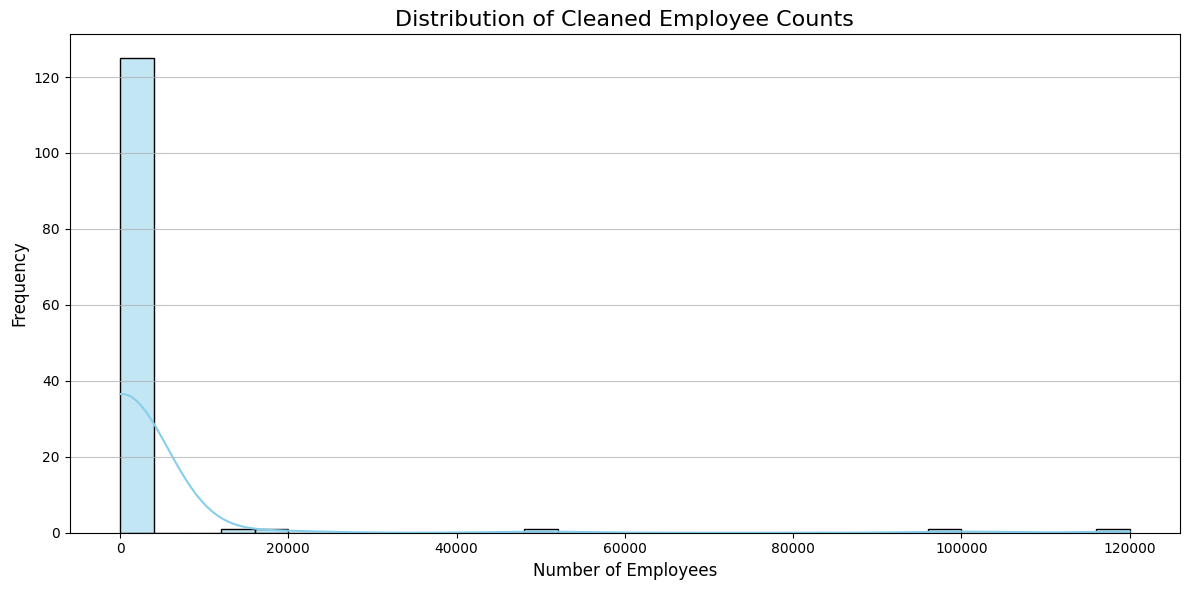

In [97]:
plt.figure(figsize=(12, 6))
sns.histplot(df['employes_cleaned'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Cleaned Employee Counts', fontsize=16)
plt.xlabel('Number of Employees', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [86]:
# --- Load Embedding Model ---
print(f"Loading embedding model '{EMBEDDING_MODEL}' ...")
model = SentenceTransformer(EMBEDDING_MODEL)


Loading embedding model 'BAAI/bge-base-en-v1.5' ...


In [87]:
# --- Encode Company + ICP Embeddings ---
company_features = df['combined_features'].tolist()

print("Encoding company descriptions...")
company_embeddings = model.encode(
    company_features,
    convert_to_tensor=True,
    show_progress_bar=True,
    batch_size=32
)

icp_embedding = model.encode(icp_description, convert_to_tensor=True)

cosine_scores = util.cos_sim(icp_embedding, company_embeddings)[0]
df['similarity_score'] = cosine_scores.cpu().numpy()


Encoding company descriptions...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [88]:
# --- Generate Explanations ---
results: List[Dict] = []

print("Generating explanations...")
for _, row in df_ranked.iterrows():
    explanation = generate_mmr_explanation(
        icp_description,
        row['short_description'],
        model,
        top_n=4
    )
    results.append({
        "company_name": row['company_name'],
        "similarity_score": round(row['similarity_score'], 4),
        "explanation": explanation
    })


Generating explanations...


In [89]:
# --- Save Output ---
output_file = "icp_ranked_companies_advanced.json"

with open(output_file, "w") as f:
    json.dump(results, f, indent=4)

print(f"Saved results to '{output_file}'.")


Saved results to 'icp_ranked_companies_advanced.json'.


In [90]:
# --- Preview Top 10 ---
for i, comp in enumerate(results[:10]):
    print(f"{i+1}. {comp['company_name']} | Score: {comp['similarity_score']}")
    print(f"   {comp['explanation']}\n")


1. Nandos Online | Score: 0.7101
   “Food and fashion delivery integrated e-commerce platform in Bangladesh.”

2. Pathao | Score: 0.709
   “Bangladeshi on-demand delivery, ride-sharing, and logistics platform expanding into e-commerce.”

3. Rangs | Score: 0.6959
   “Bangladesh-based multi-industry company selling electronics, home appliances, and fashion online.”

4. Ajkerdeal | Score: 0.6909
   “Bangladeshi e-commerce marketplace with diverse categories, including fashion and electronics.”

5. PriyoShop | Score: 0.6821
   “Bangladeshi marketplace offering fashion, electronics, and daily necessities online.”

6. Bagdoom | Score: 0.6795
   “Bangladeshi online shopping platform for fashion, electronics, and lifestyle products.”

7. Chaldal | Score: 0.6665
   “Leading online grocery delivery platform in Bangladesh with tech-first supply chain.”

8. Evaly | Score: 0.6615
   “Bangladeshi e-commerce marketplace offering flash sales and tech-driven shopping experiences.”

9. Gul Ahmed | Score